### Cartpole Linearized Dynamics: 
$$   \boldsymbol {\dot x} =f(\boldsymbol{x},\boldsymbol{u}) = Ax+Bu= \begin{bmatrix} 0 &1 &0 &0 \\0&0 & -0.98 &0\\0&0 &0 & 1 \\ 0 & 0 & 21.56 & 0 \end{bmatrix}\begin{bmatrix} x\\ \dot{x}\ \\ \theta \\ \dot{\theta}\end{bmatrix} + \begin{bmatrix} 0 \\ 1 \\ 0 \\ -2 \end{bmatrix}\begin{bmatrix}u\end{bmatrix} \quad :\boldsymbol x \in \mathbb{R}^4, \boldsymbol u \in \mathbb{R}^1$$

###Optimal Control problem (finite horizon with terminal cost): 
$$\min_{u} \mathcal{L} = \boldsymbol x(t_f)^T \boldsymbol M \boldsymbol x(t_f) + \int_{0}^{t_f}(\boldsymbol x^T\boldsymbol Q \boldsymbol x+\boldsymbol u^T\boldsymbol R \boldsymbol u )dt \quad\text{   where  } \quad t_f=2, \boldsymbol Q =\boldsymbol I_{4 \times 4}, \boldsymbol R= \boldsymbol I_{1 \times 1}, \boldsymbol M= \boldsymbol I_{4 \times 4}$$

### HJB equation:
$$ V_t = \sup_\boldsymbol u -H(\boldsymbol x,V_x, \boldsymbol u,t) = \sup_\boldsymbol u \{-(\nabla_\boldsymbol x V)^Tf(\boldsymbol x,\boldsymbol u) - \boldsymbol x^T\boldsymbol Q \boldsymbol x-\boldsymbol u^T\boldsymbol R \boldsymbol u \} $$

$$ \boldsymbol u_{opt} = -\frac{1}{2}R^{-1} B^T \nabla_\boldsymbol x V$$

Resulting PDE to solve:
$$-V_t- \boldsymbol x^T\boldsymbol Q \boldsymbol x - (\nabla_\boldsymbol x V)^T A \boldsymbol x + \frac{1}{4}(\nabla_\boldsymbol x V)^T B R^{-1} B^T(\nabla_\boldsymbol x V) = 0 \quad  $$
Subject to: $$V(2,\boldsymbol x) = \boldsymbol x^T M \boldsymbol x \quad \forall \boldsymbol x:  \begin{bmatrix} x& \dot{x} & \theta & \dot{\theta} \end{bmatrix}^T $$
state space domain:
$$ t \in [0,2],  x \in [-1,1], \dot{x} \in [-1,1], \theta \in[-\pi,\pi], \dot{\theta} \in [-1,1]$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial

In [3]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=3):
        super().__init__()
        
        self.layer_first = nn.Linear(5, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1)
        
    def forward(self, x):
        activation = nn.Tanh()
        u = activation(self.layer_first(x))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

In [4]:
t1d=torch.linspace(0,1,15,requires_grad=True)
x1d=torch.linspace(-1,1,15,requires_grad=True)
x_dot_1d=torch.linspace(-1,1,15,requires_grad=True)
th1d=torch.linspace(-3.141,3.141,15,requires_grad=True)
th_dot_1d=torch.linspace(-1,1,15,requires_grad=True)

tgrid, xgrid, x_dot_grid, thgrid, th_dot_grid = torch.meshgrid(t1d, x1d, x_dot_1d, th1d, th_dot_1d, indexing ='ij')

t=tgrid.flatten().unsqueeze(-1)
x=xgrid.flatten().unsqueeze(-1)
x_dot=x_dot_grid.flatten().unsqueeze(-1)
th=thgrid.flatten().unsqueeze(-1)
th_dot=th_dot_grid.flatten().unsqueeze(-1)

in_vec = torch.hstack((t,x,x_dot,th,th_dot))
t_bou = torch.ones((in_vec.shape[0],1),dtype=torch.float64,requires_grad=True)

A=torch.tensor([[0, 1, 0, 0], [0, 0, -0.98, 0],
                 [0, 0, 0, 1], [0, 0, 21.56, 0]],dtype=torch.float64).unsqueeze(0)

B=torch.tensor([[0, 1, 0, -2]], dtype=torch.float64).T


# 2. set the model
torch.manual_seed(23939)
model = ffnn(64, 3)

# 3. set the optimizer
lr = 0.002
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 50000
mse_loss = nn.MSELoss()
loss_history = []


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
in_vec = in_vec.to(device).float()
t_bou = t_bou.to(device).float()
model = model.to(device)
A= A.to(device)
B= B.to(device)

In [6]:
def loss_function(model, in_vec,t_bou):
  v=model(in_vec)
  v_x_1= model(torch.hstack((t_bou,in_vec[:,1:])))

  loss_v_1= (v_x_1**2).mean()
  
  v_X = torch.autograd.grad(v, in_vec,grad_outputs=t_bou,retain_graph=True,create_graph=True)[0]

  AX=torch.einsum('BNi,BiM -> BNM',A.repeat(v_X.shape[0],1,1).float(),in_vec[:,1:].unsqueeze(-1).float())

  V_XTB= torch.einsum('BNi,BiM -> BNM', v_X[:,1:].unsqueeze(1).float(), B.repeat(v_X.shape[0],1,1).float()).squeeze(-1)

  r= -v_X[:,0].view(-1,1) - torch.sum(torch.square(in_vec[:,1:]),axis =1).view(-1,1) 
  - torch.einsum('BNi,BiM -> BNM',v_X[:,1:].unsqueeze(1), AX).squeeze(-1)
  + 0.25* torch.square(V_XTB)

  loss_r = (r**2).mean()
  loss_value = loss_v_1 + loss_r
  return loss_value

In [ ]:
for i in range(n_epochs):
  loss=loss_function(model, in_vec, t_bou)
  opt.zero_grad()
  loss_history.append(loss.item())
  loss.backward()
  opt.step()
  if i % 1000 == 0:
    print(f'epoch {i}, loss = {loss}')

In [7]:
torch.save(model.state_dict(), "cartpole_mod.pth")
torch.save(loss_history, "cartpole_loss_history.pt")

# Plot the solution

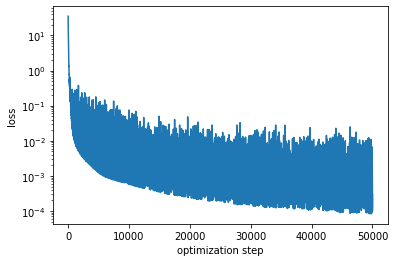

In [8]:
plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss');
plt.yscale('log')

In [8]:
model = ffnn(64,3)
model.load_state_dict(torch.load('cartpole_mod.pth',map_location='cpu'))
model.eval()

ffnn(
  (layer_first): Linear(in_features=5, out_features=64, bias=True)
  (layer_hidden): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (layer_last): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
def u(model,x):

    B=torch.tensor([[0, 1, 0, -2]], dtype=torch.float64).T
    v=model(x)
    temp = torch.ones((x.shape[0],1),requires_grad=True)
    v_x = torch.autograd.grad(v,x,grad_outputs=temp,retain_graph=True,create_graph=True)[0]
    v_x = v_x[:,1:].squeeze(0).unsqueeze(-1)
    B_numpy= B.detach().numpy()
    v_x_numpy=v_x.detach().numpy()
    u= B_numpy.T @ v_x_numpy

    return -0.5*u


In [40]:
x_init= torch.tensor([0.0364,  0.0111,  0.0055, -0.0341],requires_grad=True).unsqueeze(-1)
t1d=torch.linspace(0,1,15,requires_grad=True)

A=torch.tensor([[0, 1, 0, 0], [0, 0, -0.98, 0],
                 [0, 0, 0, 1], [0, 0, 21.56, 0]],dtype=torch.float64).unsqueeze(0)

B=torch.tensor([[0, 1, 0, -2]], dtype=torch.float64).T
x=x_init
states=[x.detach().numpy().squeeze()]
controls =[]
dt = 0.02
for t in t1d:
  in_vec=torch.tensor(torch.cat([torch.tensor([t]), x.squeeze(-1)]),
    dtype=torch.float64,requires_grad=True).unsqueeze(0).float()
  u_opt = u(model, in_vec )
  del_x=  A @ x.detach().numpy() +B @ u_opt
  del_x = del_x.view(x.shape)
  x=x + del_x*dt
  states.append(x.detach().numpy().squeeze())
  controls.append(u_opt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [41]:
states = np.asarray(states)
controls.append(controls[-1])
t1d=t1d.requires_grad_(requires_grad=False).numpy()
t1d = np.append(t1d,t1d[-1])
controls = np.asarray(controls)


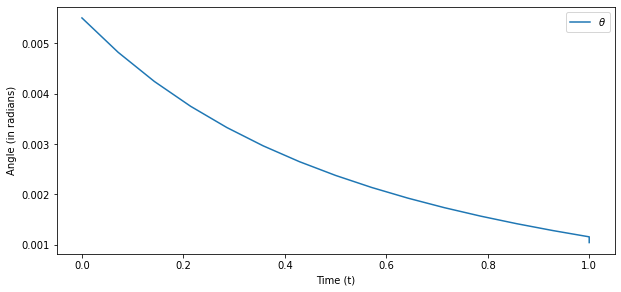

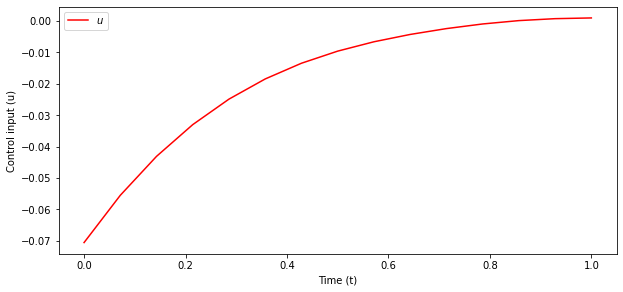

<Figure size 432x288 with 0 Axes>

In [42]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
#plt.clf()
plt.plot(t1d,states[:,2])
plt.xlabel('Time (t)')
plt.ylabel(r'Angle (in radians)')
plt.legend([r'$\theta$'])
plt.show()
#plt.savefig("Canvas12.png",dpi=500)
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 2)
plt.plot(t1d,controls.squeeze(),'r')
plt.xlabel('Time (t)')
plt.ylabel('Control input (u)')
plt.legend([r'$u$'])
plt.show()
plt.tight_layout()
plt.show()